# Accent classification with recurrent networks and i-vectors

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
#torch.multiprocessing.set_start_method("spawn")

In [3]:
# Restart from here
DEV = True
EPOCHS = 1

DEBUG = True
NUM_CONCAT = 20

In [4]:
True# autoreloads
%reload_ext autoreload
%autoreload 1
%aimport parameters

# Allows to load modules from parent directory
from time import time
import inspect, sys, os, json
from os.path import dirname, abspath
sys.path.append(dirname(dirname(abspath(inspect.getfile(inspect.currentframe())))))

from pathlib import Path
from os import makedirs

from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data.data_loader import create_binarizer, get_accents_counts
from utils import count_parameters
from models.modules import BatchRNN

from tensorboardX import SummaryWriter

import math

from torch.utils.data import DataLoader, Dataset

In [5]:
param = parameters.get_parameters(dev=DEV, epochs=EPOCHS, us_en=True)

## Utilities

In [6]:
def val_cnts(list_):
    return pd.Series(list_).value_counts()

def extract_num (s):
    return ''.join([c if c.isdigit() else '' for c in s])

def ids_list(manifest):
    ids = []
    with open(manifest) as f:
        for l in f:
            s = l.split('/')
            ids.append(f'{s[3]}-{s[5].split(".")[0]}')
    return ids

def make_accent_dict(manifest_path):
    accent_dict = {}
    class_dict = {}
    with open(manifest_path) as f:
        for l in f:
            wav, txt, acc = l.split(',')
            num = extract_num(wav)
            accent = acc.strip()
            if accent not in class_dict:
                new_key = 0 if (len(class_dict) == 0) else max(class_dict.values()) + 1
                class_dict[accent] = new_key
            accent_dict[num] = class_dict[accent]
    return accent_dict, {v: k for k, v in class_dict.items()}

def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)]))
    return torch.index_select(a, dim, order_index)

## Data Loading

In [7]:
class KaldiDataset(Dataset):
    """Defines an iterator over the dataset. This class is intended to be used with PyTorch DataLoader"""
    
    def __init__(self, data_path, sample_ids, accent_id_dict, ivectors=None):
        
        self.data_path = data_path
        self.ivectors = ivectors
        self.accent_id_dict = accent_id_dict
        if isinstance(sample_ids, list):
            self._datafiles = sample_ids
        else:
            with open(sample_ids) as f:
                self._datafiles = [x.strip() for x in f.readlines()]
        
    def __getitem__(self, index):
             
        with open(os.path.join(self.data_path, self._datafiles[index])) as f:
            sample = json.load(f)
            
        target = self.accent_id_dict[extract_num(self._datafiles[index])]
        
        if self.ivectors is None:
            return torch.FloatTensor(sample), target
        else:
            with open(os.path.join(self.ivectors, self._datafiles[index])) as f:
                ivect = json.load(f)
            return torch.FloatTensor(sample), target, torch.FloatTensor(ivect)
                      
    def __len__(self):
        
        return len(self._datafiles)

In [8]:
def collate_fn(batch_tot):
    """This function takes list of samples and assembles a batch. It is intended to used in PyTorch DataLoader."""
    batch = list(zip(*batch_tot))
    ivect = None
    
    if len(batch) == 2:
        res, tar = batch
    elif len(batch) == 3:
        res, tar, ivect = batch
        
    lens = torch.tensor([len(r) for r in res])
    tar = torch.tensor(tar)
    
    res = nn.utils.rnn.pad_sequence(res, batch_first=True)

    if ivect is not None:
        ivect = nn.utils.rnn.pad_sequence(ivect, batch_first=True)
        ivect = tile(ivect, 1, 10)
        ivect = ivect[:, :res.size(1), :]
        res = torch.cat([res, ivect], dim=2)
    
    __, idx = lens.sort(descending=True)
    return res[idx], tar[idx], lens[idx]

class KaldiDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        """
        Creates a data loader for SpeechDatasets.
        """
        super(KaldiDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = collate_fn

In [9]:
accent_id_dict, accent_dict = make_accent_dict(param['train_manifest'])

train_dataset = KaldiDataset(param['train_kaldi'], 
                              ids_list(param['train_manifest']), 
                              accent_id_dict,
                              ivectors=param['train_ivectors'])

train_loader = KaldiDataLoader(train_dataset, 
                                shuffle=True, 
                                num_workers=0,#param['num_worker'],
                                batch_size=param['batch_size'])

# for data in train_loader:
#     print(data[0])
#     print(data)
#     break

In [10]:
test_dict, __ = make_accent_dict(param['test_manifest'])

test_dataset = KaldiDataset(param['test_kaldi'], 
                              ids_list(param['test_manifest']), 
                              test_dict,
                              ivectors=param['test_ivectors'])

test_loader = KaldiDataLoader(test_dataset, 
                                shuffle=True, 
                                num_workers=param['num_worker'],
                                batch_size=param['batch_size'])

## Model definition

In [11]:
class AccentClassifier(nn.Module):
    def __init__(self,
                 input_size,
                 num_classes,
                 rnn_type,
                 hidden_size,
                 bn_size,
                 DEBUG = False,):
        
        super(AccentClassifier, self).__init__()
        
        self.hidden_size = hidden_size

        self._DEBUG = DEBUG
        
        self.rnn = rnn_type(input_size, hidden_size, 2, 
                            bidirectional=True, 
                            batch_first=True)

#         self.rnn = BatchRNN(input_size, 
#                             hidden_size,
#                             rnn_type=rnn_type,bidirectional=True,
#                             batch_norm=True)
        
        self.bn = nn.Sequential(
            nn.BatchNorm1d(hidden_size * 2),
            nn.Linear(hidden_size * 2, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, bn_size),
            nn.ReLU(),
        )
            
        self.fc = nn.Sequential(
            nn.BatchNorm1d(bn_size),
            nn.Linear(bn_size, num_classes),
            nn.ReLU(),
        )
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, lens):
        if self._DEBUG:
            print('input x', x.size())

        x = nn.utils.rnn.pack_padded_sequence(x, lens, batch_first=True)
        x, __ = self.rnn(x)
        x, lens = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        
        if self._DEBUG:
            print('after rnn', x.size())
#        
#         x = x.view(x.size(0), x.size(1), 2, self.hidden_size)
        
#         if self._DEBUG:
#             print('after view', x.size())
            
        x = x.mean(dim=1)
        
        if self._DEBUG:
            print('after mean', x.size())
            
        x = self.bn(x)
        bn = x
        
        if self._DEBUG:
            print('after bn', x.size())

        x = self.fc(x)
        
        if self._DEBUG:
            print('after fc', x.size())
            
        x = self.softmax(x)
        
        if self._DEBUG:
            print('after softmax', x.size())
            
        self._DEBUG = False
        return x, bn

## Optimizer

In [12]:
model = AccentClassifier(input_size=train_dataset[0][0].size(1) + 100, 
                         num_classes=len(accent_dict),
                         rnn_type=param['rnn_type'],
                         hidden_size=param['rnn_hidden_size'],
                         bn_size=param['bn_size'],
                         DEBUG=DEBUG)

if param['cuda']:
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'][0])

print(model)
print('Model parameters counts:', count_parameters(model))

AccentClassifier(
  (rnn): GRU(140, 40, num_layers=2, batch_first=True, bidirectional=True)
  (bn): Sequential(
    (0): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=80, out_features=1024, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=1024, out_features=100, bias=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=100, out_features=2, bias=True)
    (2): ReLU()
  )
  (softmax): Softmax()
)
Model parameters counts: 261014


## Training

In [13]:
def train(epochs, 
          model, 
          train_loader, 
          test_loader, 
          optimizer, 
          criterion, 
          silent=True,
          exp_name='__tmp__'):

    # Tensorboard
    tb_path = Path(param['tensorboard_dir']) / exp_name
    makedirs(tb_path, exist_ok=True)
    tb_writer = SummaryWriter(tb_path)

    prev_epoch_val_loss = math.inf
    
    ## Train
    for epoch in range(1, param['epochs'] + 1):
        print(f'## EPOCH {epoch} ##')
        print(f'Training:')
        model.train()

        # train
        epoch_losses = []
        for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs, target_accents, lens = data
            inputs = inputs.cuda()
            target_accents = target_accents.cuda()
            lens = lens.cuda()

            # Forward pass
            out, __ = model(inputs, lens)

            loss = criterion(out, target_accents)
            epoch_losses.append(loss)

            if not silent:
                print(f'Iteration {i+1}/{len(train_loader):<4}loss: {loss:0.3f}')

            # Gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = sum(epoch_losses) / len(train_loader)
        tb_writer.add_scalar('stats/train_loss', epoch_loss, epoch)
        print(f'Epoch {epoch} average loss: {epoch_loss:0.3f}')

        # validate
        print(f'Testing:')
        model.eval()
        acc = 0
        tot = 0
        with torch.no_grad():
            epoch_val_losses = []
            for data in tqdm(test_loader, total=len(test_loader)): ## ## 
                inputs, target_accents, lens = data
                inputs = inputs.cuda()
                target_accents = target_accents.cuda()

                out, __ = model(inputs, lens)

                val_loss = criterion(out, target_accents)
                epoch_val_losses.append(val_loss)

                out_arg = np.argmax(out, axis=1).cuda()
                diff = torch.eq(out_arg, target_accents)
                acc += torch.sum(diff)
                tot += len(target_accents)

            acc = acc.item() / tot * 100
            epoch_val_loss = sum(epoch_val_losses) / len(test_loader) ##

        tb_writer.add_scalar('stats/accuracy', acc, epoch)
        print(f'Accent classification accuracy: {acc:0.2f}%')

        tb_writer.add_scalar('stats/val_loss', epoch_val_loss, epoch)
        print(f'Average validation loss: {val_loss:0.3f}')

        if epoch_val_loss < prev_epoch_val_loss:
            print('New best model found.')
            best_model = model
            prev_epoch_val_loss = epoch_val_loss
            
    return best_model, prev_epoch_val_loss

In [15]:
SILENT = True
best_models = {}

settings = {'rnn_type': [nn.GRU],
            'rnn_hidden_size': [600],
            'bn_size': [1024]}

for _rnn_type in settings['rnn_type']:
    for _rnn_hidden_size in settings['rnn_hidden_size']:
        for _bn_size in settings['bn_size']:
            exp_name = f'{_rnn_type}_hidden-{_rnn_hidden_size}_bn-{_bn_size}_{time()}'

            model = AccentClassifier(input_size=train_dataset[0][0].size(1) + 100, 
                                     num_classes=len(accent_dict),
                                     rnn_type=_rnn_type,
                                     hidden_size=_rnn_hidden_size,
                                     bn_size=_bn_size,
                                     DEBUG=DEBUG)

            if param['cuda']:
                model.cuda()

            criterion = nn.CrossEntropyLoss()

            optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'][0])

            print()
            print(f'{"":#<13}')
            print(exp_name)
            print(f'{"":#<13}')

            model, val_loss = train(param, 
                                    model,
                                    train_loader, 
                                    test_loader, optimizer, 
                                    criterion,
                                    silent=SILENT,
                                    exp_name=exp_name)
            best_models[exp_name] = (model, val_loss.item())
        
        
print(f'{"":#<13}')

best_model = None
best_name = None
prev_v = math.inf
for name, (m, v) in best_models.items():
    if v < prev_v:
        best_model = m
        best_name = name
print(f'best overall model:', best_name) 


#############
<class 'torch.nn.modules.rnn.GRU'>_hidden-600_bn-1024_1548930300.2474542
#############
## EPOCH 1 ##
Training:


input x torch.Size([20, 694, 140])
after rnn torch.Size([20, 694, 1200])
after mean torch.Size([20, 1200])
after bn torch.Size([20, 1024])
after fc torch.Size([20, 2])
after softmax torch.Size([20, 2])

Epoch 1 average loss: 0.652
Testing:



Accent classification accuracy: 38.80%
Average validation loss: 0.794
New best model found.
#############
best overall model: <class 'torch.nn.modules.rnn.GRU'>_hidden-600_bn-1024_1548930300.2474542


In [ ]:
input x torch.Size([20, 692, 140])
after rnn torch.Size([20, 692, 1200])
after mean torch.Size([20, 1200])
after bn torch.Size([20, 1024])
after fc torch.Size([20, 2])
after softmax torch.Size([20, 2])

## Tests

In [14]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black") #if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [15]:
loader = test_loader
best_model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for data in tqdm(loader, total=len(loader)):
        inputs, target_accents, lens = data
        inputs = inputs.cuda()
        target_accents = target_accents.cuda()
        
        out, __ = best_model(inputs, lens)
        
        y_true.extend(target_accents)
        y_pred.append(np.argmax(out, axis=1))
        
    y_pred = torch.cat(y_pred)
            
    y_true_labels = [accent_dict[int(i)] for i in y_true]
    y_pred_labels = [accent_dict[int(i)] for i in y_pred]

cnf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=list(accent_dict.values()))

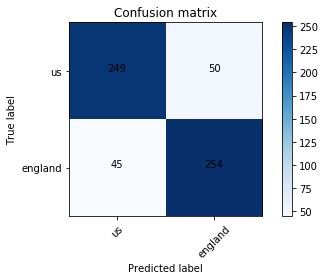

In [16]:
plot_confusion_matrix(cnf_mat, classes=accent_dict.values(), normalize=False)

In [17]:
from sklearn import metrics
print(metrics.classification_report(y_true_labels, y_pred_labels))

             precision    recall  f1-score   support

    england       0.84      0.85      0.84       299
         us       0.85      0.83      0.84       299

avg / total       0.84      0.84      0.84       598



## Clustering

In [41]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.manifold import TSNE

def plot_pca(X, y, _dict, projection='PCA', graph_title=''):
    if projection == 'PCA':
        Y = sklearnPCA(n_components=2).fit_transform(X)
    elif projection == 'TSNE':
        Y = TSNE(n_components=2).fit_transform(X)
    else:
        raise ValueError(f'Projection {projection} unkown.')

    plt.figure(figsize=(6, 4))
    for lab in _dict.values():
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.title(f'{projection}: {graph_title}')
    plt.show()

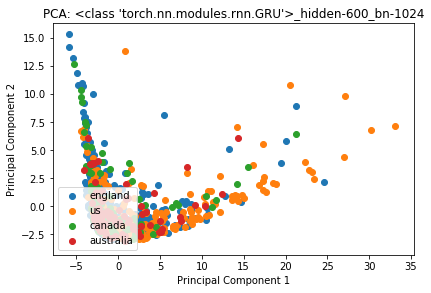

In [42]:
loader = test_loader
projection = 'PCA'

for model_name, (model, val_loss) in best_models.items():
    datapoints = []
    targets = []
    
    model.eval()
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader)):
            
            inputs, target_accents, lens = data
            inputs = inputs.cuda()
            __, bn = best_model(inputs, lens)

            datapoints.append(bn)
            targets.append(target_accents)
            
    datapoints = torch.cat(datapoints)
    targets = torch.cat(targets)
    
    X = np.asarray(datapoints)
    y = np.asarray([accent_dict[t.item()] for t in targets])
    
    plot_pca(X, y, accent_dict, projection=projection, graph_title=model_name)